# Boston House Price Prediction

In [1]:
# import required library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats

from sklearn.linear_model import LassoCV, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')


## Reading Dataset

In [2]:
# load dataset from sklearn 
boston_dataset = datasets.load_boston()
# load datset as pandas datsframe 
data = pd.DataFrame(boston_dataset.data,columns=boston_dataset.feature_names)
data['target'] = boston_dataset.target
# print 10 sample rows
data.sample(10)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
487,4.83567,0.0,18.10,0.0,0.583,5.905,53.2,3.1523,24.0,666.0,20.2,388.22,11.45,20.6
178,0.06642,0.0,4.05,0.0,0.510,6.860,74.4,2.9153,5.0,296.0,16.6,391.27,6.92,29.9
196,0.04011,80.0,1.52,0.0,0.404,7.287,34.1,7.3090,2.0,329.0,12.6,396.90,4.08,33.3
442,5.66637,0.0,18.10,0.0,0.740,6.219,100.0,2.0048,24.0,666.0,20.2,395.69,16.59,18.4
94,0.04294,28.0,15.04,0.0,0.464,6.249,77.3,3.6150,4.0,270.0,18.2,396.90,10.59,20.6
107,0.13117,0.0,8.56,0.0,0.520,6.127,85.2,2.1224,5.0,384.0,20.9,387.69,14.09,20.4
163,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
143,4.09740,0.0,19.58,0.0,0.871,5.468,100.0,1.4118,5.0,403.0,14.7,396.90,26.42,15.6
498,0.23912,0.0,9.69,0.0,0.585,6.019,65.3,2.4091,6.0,391.0,19.2,396.90,12.92,21.2
352,0.07244,60.0,1.69,0.0,0.411,5.884,18.5,10.7103,4.0,411.0,18.3,392.33,7.79,18.6


In [3]:
#print basic info
print(f"Contains {data.shape[0]} rows and {data.shape[1]-1} feature and contimous target variable")

Contains 506 rows and 13 feature and contimous target variable


In [4]:
# describing the feature name and attribute information
print(boston_dataset.DESCR)


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Thoughts...
1. No missing value are given
2. As target value is represnted as median , there are chances that dataset contain outliers.
3. Most of the feature correlates the target value.
4. Feature have different scales.

# Data Exploration

In [5]:
# checking for any missing value
print("Missing values for every features.")
data.isna().sum()

Missing values for every features.


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

As given there are no missing values

In [6]:
# check datatype and na values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


All data is in numeric(float64)

In [7]:
#describe dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [8]:
# check if rows are duplicte or not
print(f"There are {data.duplicated().sum()} rows in dataset.")

There are 0 rows in dataset.


## Thoughts...
1. Dataset dosent contain any null values.
2. All features and target vatriable are numeric(float64), `CHAS` is an categorical varible.
3. Features `CHAS`, `NOX` and `ZN` have more than 50% value as zero.
4. Most of the feature contain outliers that need to fixed.
5. There are no duplicated rows



### Feature Engineering

In [9]:
def distribution_plot(data):
    columns = data.columns
    fig, ax = plt.subplots(14,2,figsize=(16,64) )
    for ii, col_name in enumerate(columns):
        sns.violinplot(data[col_name], ax=ax[ii][0], orient='v')
        ax[ii][0].set_title(f"{col_name} Violin Plot",)
        sns.distplot(data[col_name], ax=ax[ii][1], kde=False)
        ax[ii][1].set_title(f"{col_name} Distribution Plot",)

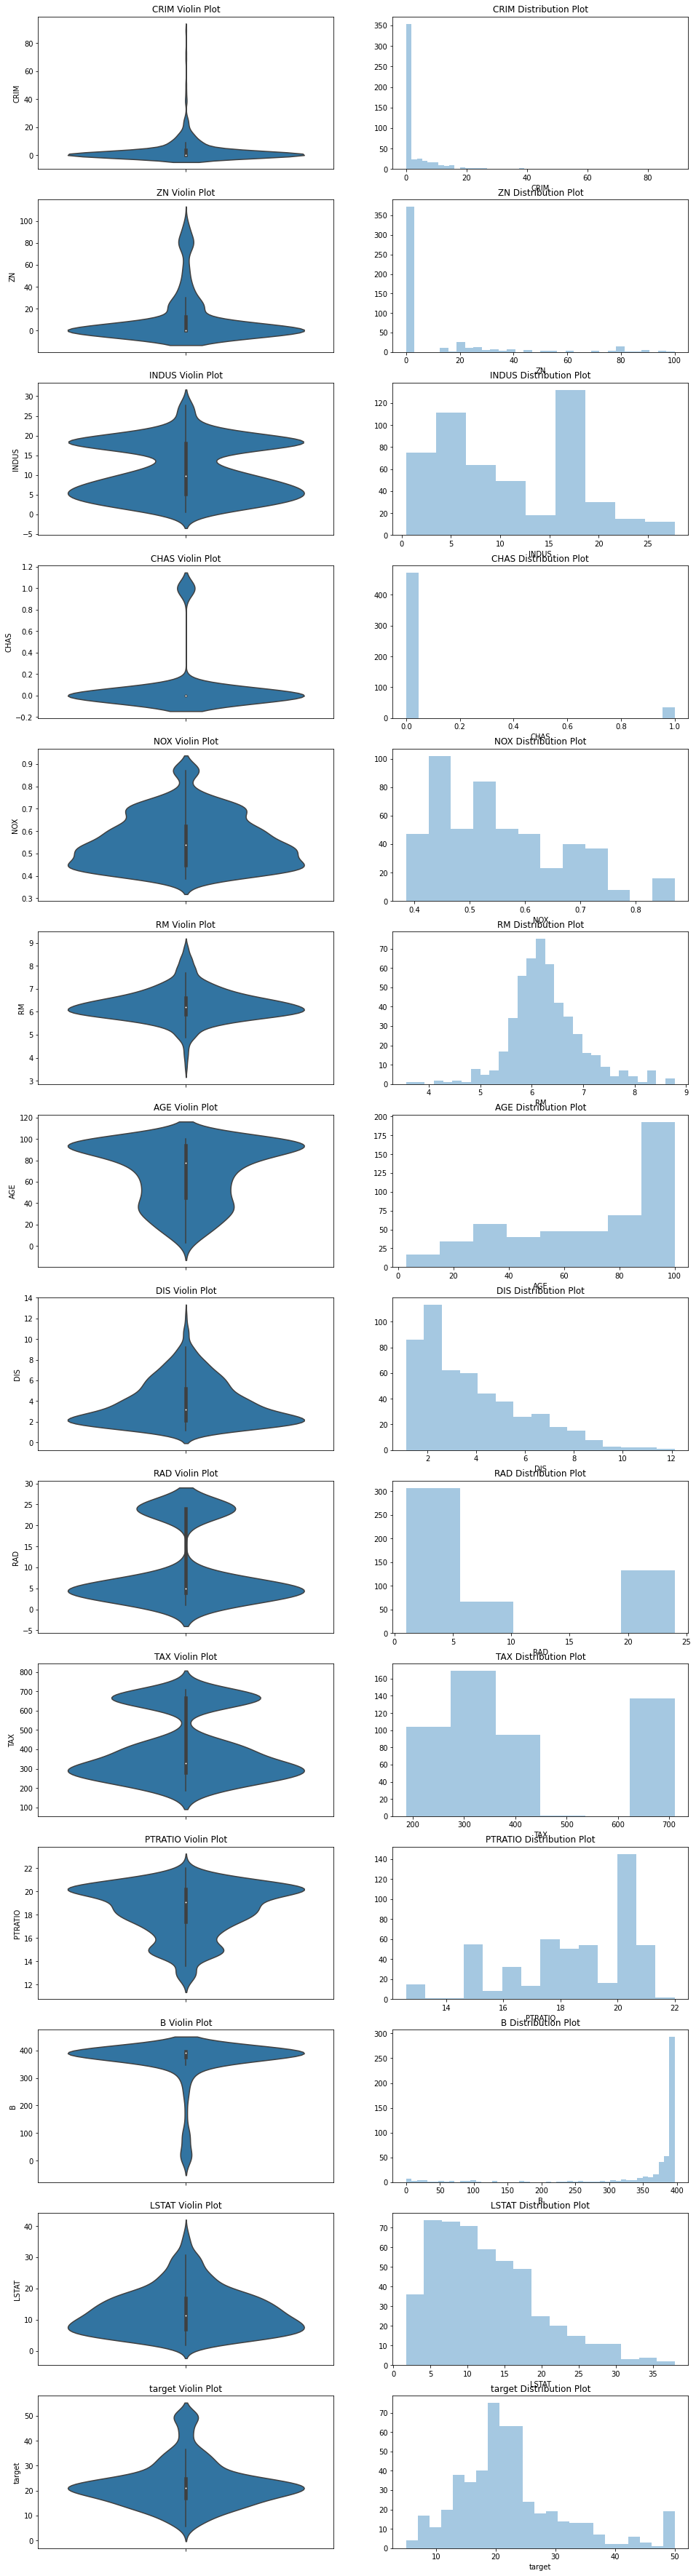

In [10]:
distribution_plot(data)

* `CRIM`, `ZN` and features are `left skewed`.
* `B` is `right skewed`.
* `target` is normally distributed.
* `CRIM`, `ZN` ,`CHAS`, `RN` ,`B` and `Target` seems to have outlier.

In [11]:
# removing Outliers
data = data[(np.abs(stats.zscore(data))<3).all(axis=1)]

In [12]:
#checking stats
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,415.000000,415.000000,415.000000,415.0,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,2.452461,9.602410,10.829687,0.0,0.547168,6.267554,67.384337,3.852640,8.684337,393.853012,18.467952,374.235373,12.275976,22.353976
std,4.897241,19.677404,6.798613,0.0,0.110428,0.611602,28.072043,1.964763,8.196802,161.196133,2.137611,51.582784,6.474602,8.077366
min,0.006320,0.000000,0.460000,0.0,0.385000,4.368000,2.900000,1.169100,1.000000,188.000000,12.600000,83.450000,1.730000,5.600000
25%,0.081005,0.000000,5.130000,0.0,0.449000,5.886000,43.550000,2.203200,4.000000,279.000000,17.400000,377.880000,7.210000,17.550000
50%,0.211610,0.000000,8.560000,0.0,0.524000,6.193000,73.900000,3.377900,5.000000,315.000000,19.000000,392.630000,11.220000,21.200000
75%,2.152115,12.500000,18.100000,0.0,0.609000,6.559500,93.700000,5.287300,8.000000,437.000000,20.200000,396.900000,16.215000,24.800000
max,28.655800,80.000000,27.740000,0.0,0.871000,8.337000,100.000000,9.222900,24.000000,711.000000,21.200000,396.900000,31.990000,50.000000


* `CHAS` feture is only containing '0'. 

In [13]:
#droping CHAS feature as it only contains 0
data.drop('CHAS',axis=1, inplace=True)

In [14]:
data.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,2.452461,9.602410,10.829687,0.547168,6.267554,67.384337,3.852640,8.684337,393.853012,18.467952,374.235373,12.275976,22.353976
std,4.897241,19.677404,6.798613,0.110428,0.611602,28.072043,1.964763,8.196802,161.196133,2.137611,51.582784,6.474602,8.077366
min,0.006320,0.000000,0.460000,0.385000,4.368000,2.900000,1.169100,1.000000,188.000000,12.600000,83.450000,1.730000,5.600000
25%,0.081005,0.000000,5.130000,0.449000,5.886000,43.550000,2.203200,4.000000,279.000000,17.400000,377.880000,7.210000,17.550000
50%,0.211610,0.000000,8.560000,0.524000,6.193000,73.900000,3.377900,5.000000,315.000000,19.000000,392.630000,11.220000,21.200000
75%,2.152115,12.500000,18.100000,0.609000,6.559500,93.700000,5.287300,8.000000,437.000000,20.200000,396.900000,16.215000,24.800000
max,28.655800,80.000000,27.740000,0.871000,8.337000,100.000000,9.222900,24.000000,711.000000,21.200000,396.900000,31.990000,50.000000


[]

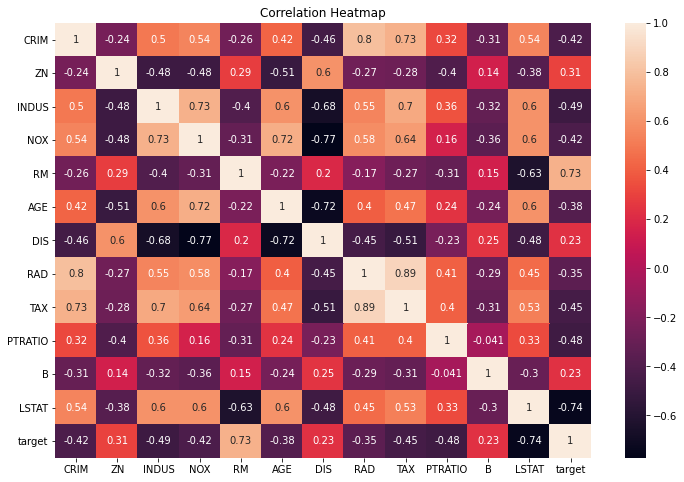

In [15]:
# analyzing how features correlates with one and orther
corr_matrix = data.corr()
# plot heatmap
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_matrix, annot=True)
ax.set_title("Correlation Heatmap")
plt.plot()

* features like `LSTAT`, `PTRATIO`, `TAX`, `INDUS` and `RM` highly correlates with target variable. (IMP features).
* feature `TAX` and `RAD` have strong correlation index. 
* feature `DIS` and `NOX` have strong correlation index. 
* feature `CHAS` dosen't contribute much to prediction. Need to verify.

In [16]:
#removing RAD and DIS features
# data = data.drop(['RAD','DIS'], axis=1) # correlated features with least contribution

[]

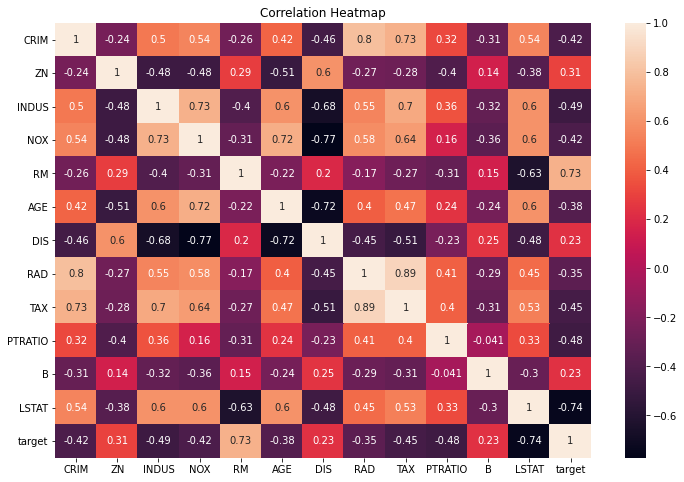

In [17]:
# analyzing how features correlates with one and orther
corr_matrix = data.corr()
# plot correation heatmap
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_matrix, annot=True)
ax.set_title("Correlation Heatmap")
plt.plot()

* Features like `INDUS`, `RM`, `TAX`, `PTRATIO` and `LSTAT` have high correlation(>.45) with target variable.

In [18]:
# Removing feature eith correlation less tha 0.40 with target feature
features_to_remove = ['ZN', 'AGE', 'B']
data.drop(features_to_remove, axis=1, inplace=True)

In [19]:
# Removing skewness
for feature_name in data.columns[:-1]:
    data[feature_name] = data[feature_name] if -0.3 < data[feature_name].skew() < 0.3 else data[feature_name].apply(np.log1p)


#### How high correlated feature contribute to target variable

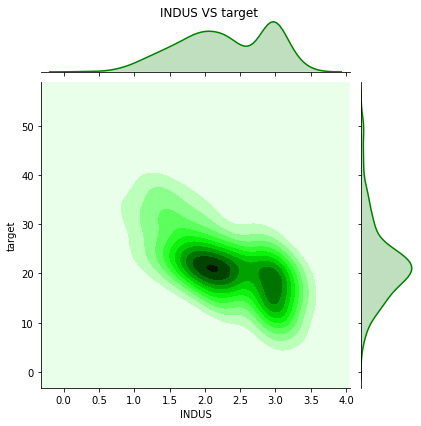

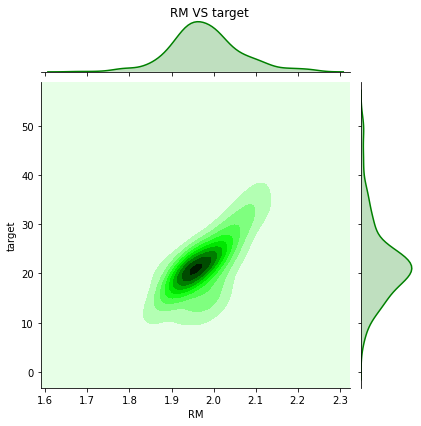

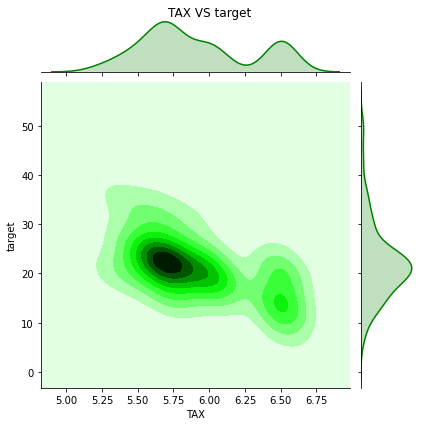

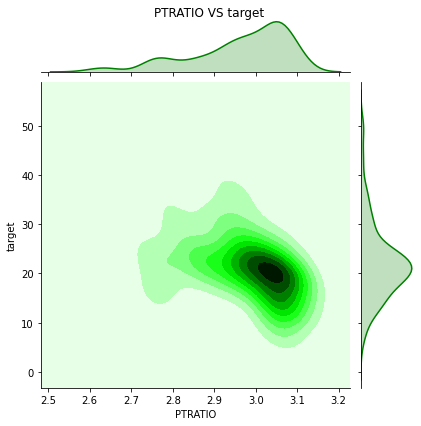

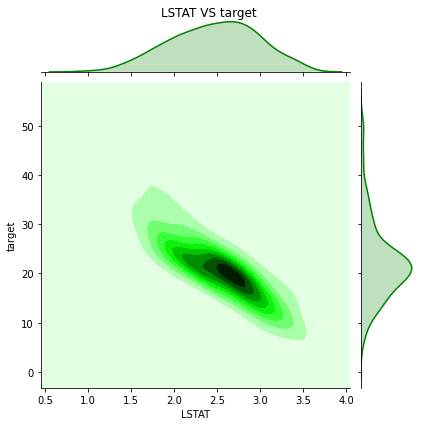

In [20]:

imp_features = ['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
for ii, feature in enumerate(imp_features):
    
    ax = sns.jointplot(feature, 'target', data=data,
              kind="kde", color="g");
    ax.fig.suptitle(f"{feature} VS target")
    ax.fig.subplots_adjust(top=0.95)


In [21]:
# reset index of dataframe
data = data.reset_index(drop=True)

In [22]:
#standerlizing feature into same scale

## creating feature and target datframe
features = data.drop('target',axis=1)
target = data['target']

# feature Dataframe after Standarlizaion
features = pd.DataFrame(StandardScaler().fit_transform(features),columns=features.columns)
# print top 5 rows of new feature dataframe
features.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.759508,1.312423,-1.705866,-0.050211,0.541925,0.169433,0.320472,-1.800543,-0.549683,-1.471021,0.352296,-1.351689
1,-0.736617,-0.583564,-0.307677,-0.710817,0.293975,0.483252,0.725112,-1.234989,-1.076992,-0.244291,0.352296,-0.297911
2,-0.736638,-0.583564,-0.307677,-0.710817,1.476888,0.062765,0.725112,-1.234989,-1.076992,-0.244291,0.304249,-1.696918
3,-0.731169,-0.583564,-1.768726,-0.818990,1.197887,-0.409164,1.153962,-0.833722,-1.302687,0.157723,0.325559,-2.184306
4,-0.692454,-0.583564,-1.768726,-0.818990,1.420712,-0.133745,1.153962,-0.833722,-1.302687,0.157723,0.352296,-1.238184


In [23]:
#save feature and target dataframe
features.to_csv('./data/features_init.csv', index=False)
target.to_csv('./data/target.csv', index=False)

## Building Model

In [24]:
# Suffle and split dataset into train and val
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=2)


### Linear Model

In [25]:
# fit linear Regression Model
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
predict = lr.predict(X_test)
print("Linear Regression metric")
print(f"R2 score :{r2_score(y_test, predict)},\nMSE : {mean_squared_error(y_test, predict)}")

Linear Regression metric
R2 score :0.7950904323837061,
MSE : 15.355870540315754


In [26]:
# Kfold 
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv = KFold(n_splits=10, shuffle=True,)

In [27]:
# fit Lasso Regression Model for retrieving imp features
lasso = LassoCV(cv=cv)
lasso = lasso.fit(X_train, y_train)
predict = lasso.predict(X_test)
print("LASSO Regression metric")
print(f"R2 score :{r2_score(y_test, predict)},\nMSE : {mean_squared_error(y_test, predict)}")

LASSO Regression metric
R2 score :0.7933263147769039,
MSE : 15.488073062155413


In [28]:
# analyzing Lasso coef
dict(zip(features.columns,lasso.coef_))

{'CRIM': -0.4061939505987069,
 'ZN': -0.06089798145662313,
 'INDUS': -0.23348959528876057,
 'NOX': -1.2476683312926602,
 'RM': 1.4403581276348376,
 'AGE': 0.053577514481232255,
 'DIS': -2.7494937484471573,
 'RAD': 1.6526165777856978,
 'TAX': -1.4358397496619641,
 'PTRATIO': -1.643308105488819,
 'B': 0.49995364903123934,
 'LSTAT': -4.835454680788125}

* Following features contributes a lot. (>1)

    1. RM
    2. PTRATIO
    3. LSTAT
    4. TAX
    
Above features looks important for prediction.
* `NOX` is redundant feature as lasso coef is zero. 

Training Lasso and Linear Regression on above features to check accuracy.

In [29]:
beta_feature_name = ['NOX', 'DIS', 'RAD', 'RM', 'PTRATIO', 'LSTAT','TAX']
X_train_beta, X_test_beta = X_train[beta_feature_name], X_test[beta_feature_name]

In [30]:
# fit linear Regression Model on beta features
lr = LinearRegression()
lr = lr.fit(X_train_beta, y_train)
predict = lr.predict(X_test_beta)
print("Linear Regression metric")
print(f"R2 score :{r2_score(y_test, predict)},\nMSE : {mean_squared_error(y_test, predict)}")

Linear Regression metric
R2 score :0.7935977854634094,
MSE : 15.467729118405178


In [31]:
# fit Lasso Regression Model on beta features
lasso = LassoCV(cv=cv)
lasso = lasso.fit(X_train_beta, y_train)
predict = lasso.predict(X_test_beta)
print("Linear Regression metric")
print(f"R2 score :{r2_score(y_test, predict)},\nMSE : {mean_squared_error(y_test, predict)}")

Linear Regression metric
R2 score :0.793599953418191,
MSE : 15.467566652428847


* Accuracy increased by `~.5%`.


### Thoughts...
* Accuracy incresed with beta features.
* Need to extract more revelent features from dataset

### Model training and evaluation

In [32]:
# Extractring feature using Polynomial feature
revelent_feature = {}
score = {}
for degree in range(1,5):
    model = make_pipeline(PolynomialFeatures(degree=degree),LassoCV(cv=cv, max_iter=5000, normalize=True))
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    imp_feature = dict(filter(lambda x: abs(x[1])>1, dict(zip(model[0].get_feature_names(), model[1].coef_)).items()))
    revelent_feature.update(imp_feature)
    score[degree] = {'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}

/home/ratnesh/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6697743484577359, tolerance: 1.5537812413793102
  positive)
/home/ratnesh/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9625024083768494, tolerance: 1.5537812413793102
  positive)


[]

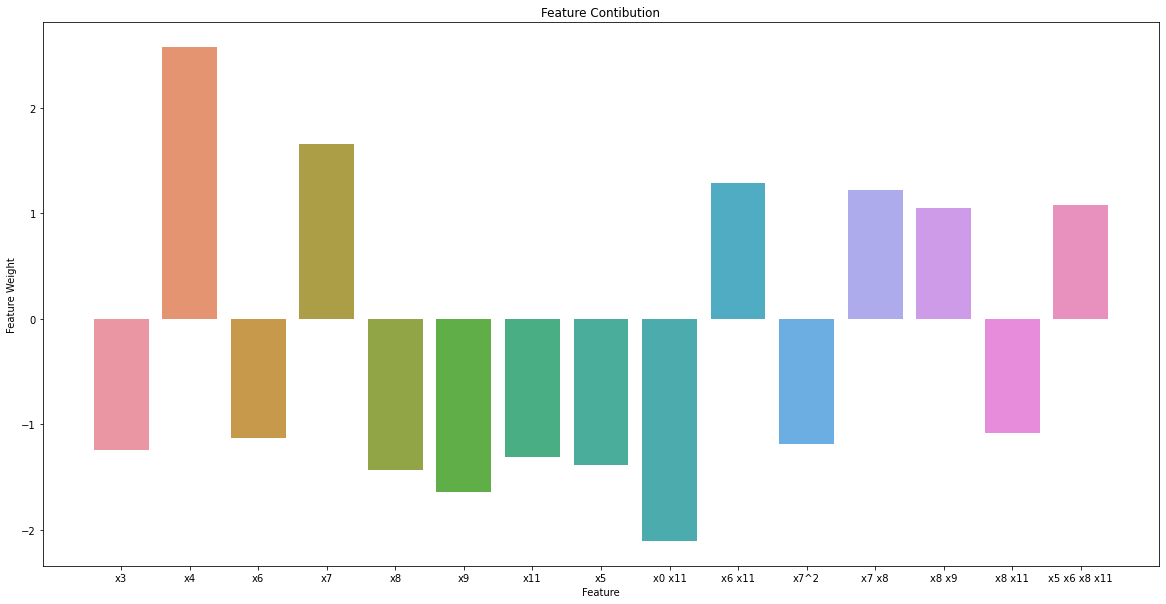

In [33]:
# Revelent feature extracted
plt.figure(figsize=(20,10))
ax = sns.barplot(x=list(revelent_feature.keys()), y = list(revelent_feature.values()))
ax.set_title('Feature Contibution')
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Weight')
plt.plot()

Text(0.5, 0, 'Feature Degree')

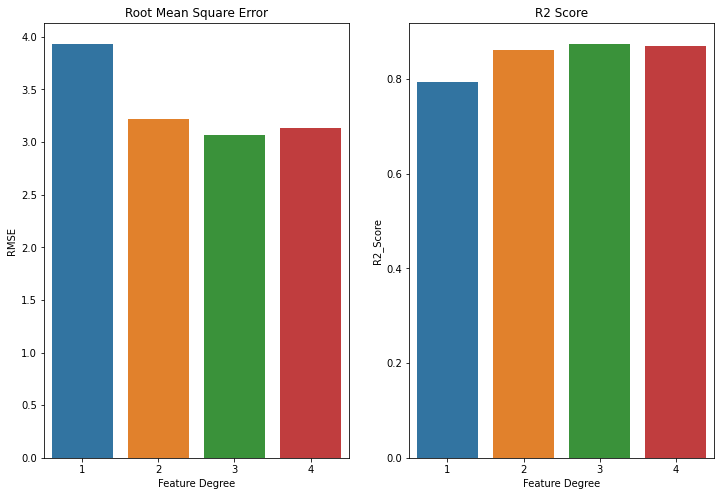

In [34]:
# score for each polynomialfeature 
df = pd.DataFrame(score)

fig, ax = plt.subplots(1,2,sharex=True, figsize=(12,8))
sns.barplot(x=list(range(1,5)), y =df.iloc[1,:],ax=ax[0])
ax[0].set_title("Root Mean Square Error")
ax[0].set_xlabel('Feature Degree')

sns.barplot(x=list(range(1,5)), y =df.iloc[0,:],ax=ax[1])
ax[1].set_title("R2 Score")
ax[1].set_xlabel('Feature Degree')

In [35]:
#print score
df

,1,2,3,4
R2_Score,0.793328,0.861850,0.874244,0.869259
RMSE,3.935469,3.217602,3.069873,3.130125


* After degree 3 the R2 score start to decrease.  Extracting more feature will lead to decrease in accuracy
* Highest accuracy attained is .87 . Its about 10% increase compared to previous models

### Support Vector Mechanies

In [36]:
# Extractring feature using Polynomial feature

score = {}
for degree in range(1,5):
    model = make_pipeline(PolynomialFeatures(degree=degree),SVR(C=1, kernel='poly'))
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    score[degree] = {'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}
score

{1: {'R2_Score': 0.7557605737740588, 'RMSE': 4.278228614284061},
 2: {'R2_Score': 0.5033336648603224, 'RMSE': 6.100823551684284},
 3: {'R2_Score': 0.1988124757977947, 'RMSE': 7.748599096592046},
 4: {'R2_Score': -0.07034009044824252, 'RMSE': 8.9560600919784}}

In [37]:
prams = {
    "C" : [0.1, 1, 10, 100, 128, 156, 200, 225, 256, 300, 350],
    'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 , 1, 3, 5]
}

error_fn = lambda model, x, y : -mean_squared_error(y, model.predict(x))

grid = GridSearchCV(SVR(kernel='rbf'), prams, error_fn, cv=cv)

In [38]:
#grid search
grid_result = grid.fit(X_train, y_train)

# load best estimator
svm = grid_result.best_estimator_

In [39]:
svm

SVR(C=256, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma=0.05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
# SVR metric
predict = svm.predict(X_test)

print("Support Vector Machine Regressor Metric")
{'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}

Support Vector Machine Regressor Metric


{'R2_Score': 0.9053856925250331, 'RMSE': 2.6627752404045117}

### Desicion Tree Regressor

### Model complexity

In [41]:
max_depth = range(1,10)

In [42]:
train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X_train, y_train, \
        param_name = "max_depth", param_range = range(1,10), cv = cv, scoring = 'r2')

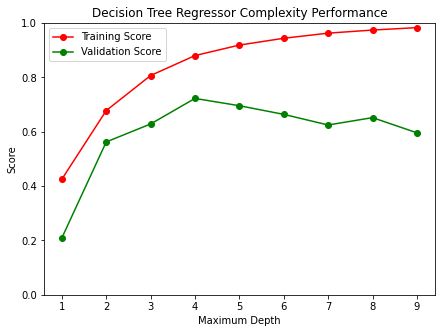

In [43]:

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(7, 5), frameon=False)
plt.title('Decision Tree Regressor Complexity Performance')
plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')

# Visual aesthetics
plt.legend()
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.ylim([0.0,1.0])
plt.show()

### Thoughts...
After max depth of 4 model start to overfit. Depth of 4 seems a good fir for the model.

In [44]:
# Create a decision tree regressor object
regressor = DecisionTreeRegressor()

# Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
params = {'max_depth': max_depth}

# Transform 'performance_metric' into a scoring function using 'make_scorer' 
performance_metric = lambda y_true, y_pred : r2_score(y_true, y_pred)
# scoring_fnc = make_scorer(performance_metric)

# Create the grid search cv object --> GridSearchCV()
grid = GridSearchCV(regressor, params, scoring = error_fn, cv = cv)

# Fit the grid search object to the data to compute the optimal model
grid = grid.fit(X_train, y_train)


In [45]:
dtree_reg = grid.best_estimator_

Our Assumption was right. max depth of 4 is a good fit for the model.

In [46]:
# Decision Tree metric
predict = dtree_reg.predict(X_test)

print("Decision Tree Regressor Metric")
{'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}

Decision Tree Regressor Metric


{'R2_Score': 0.81487912725267, 'RMSE': 3.724635661744849}

### Random Forest

In [47]:
train_scores, test_scores = validation_curve(RandomForestRegressor(n_estimators=12), X_train, y_train, \
        param_name = "max_depth", param_range = range(1,10), cv = cv, scoring = 'r2')

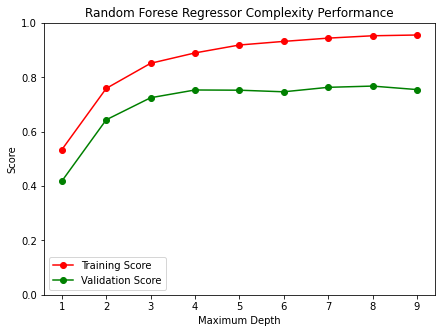

In [48]:

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(7, 5), frameon=False)
plt.title('Random Forese Regressor Complexity Performance')
plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')

# Visual aesthetics
plt.legend()
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.ylim([0.0,1.0])
plt.show()

In [49]:
# Create a decision tree regressor object
rf_reg = RandomForestRegressor(n_estimators=12)

# Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
params = {'max_depth': max_depth}

# Transform 'performance_metric' into a scoring function using 'make_scorer' 
performance_metric = lambda y_true, y_pred : r2_score(y_true, y_pred)
# scoring_fnc = make_scorer(performance_metric)

# Create the grid search cv object --> GridSearchCV()
grid = GridSearchCV(rf_reg, params, scoring = error_fn, cv = cv)

# Fit the grid search object to the data to compute the optimal model
grid = grid.fit(X_train, y_train)


In [50]:
rf_reg = grid.best_estimator_

In [51]:
# Decision Tree metric
predict = rf_reg.predict(X_test)

print("Random forest Regressor Metric")
{'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}

Random forest Regressor Metric


{'R2_Score': 0.8663005699355646, 'RMSE': 3.165343750996832}

### Thoughts ...
The R2 score of decision tree and random forest is low as compared to SVM. As the desion tree have high variance ie they overfit easilty we find that max depth of  4 seems to be a good choice. Can b further used in feature selector

### XG boost 
As most of the top solutions in any ml competions have final model as xgboost. It will be good to check out how it performs in this data.

In [52]:
# Xgboost Dmtrix for fast processing
dmatrix = DMatrix(data=X_train,label=y_train)

In [53]:
# Search best params

# xgb ression
xgb_reg = XGBRegressor()
# Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
params = {
   'colsample_bytree':[0.3, 0.4, 0.5, 0.6, 0.7],
   'gamma':[0, 0.05, 0.01 ,0.1 ,0.5],
   'learning_rate':[0.001, 0.01, 0.1],
   'max_depth':[2, 3, 4, 5, 6, 7],
   'n_estimators':[5, 10, 15, 25, 50, 100],
   'subsample':[0.6, 0.7, 0.8, 0.9]  
}



# Create the grid search cv object --> GridSearchCV()
grid = GridSearchCV(xgb_reg, params, scoring = error_fn, cv = cv)

# Fit the grid search object to the data to compute the optimal model
grid = grid.fit(X_train, y_train)

In [54]:
# print best parameters
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

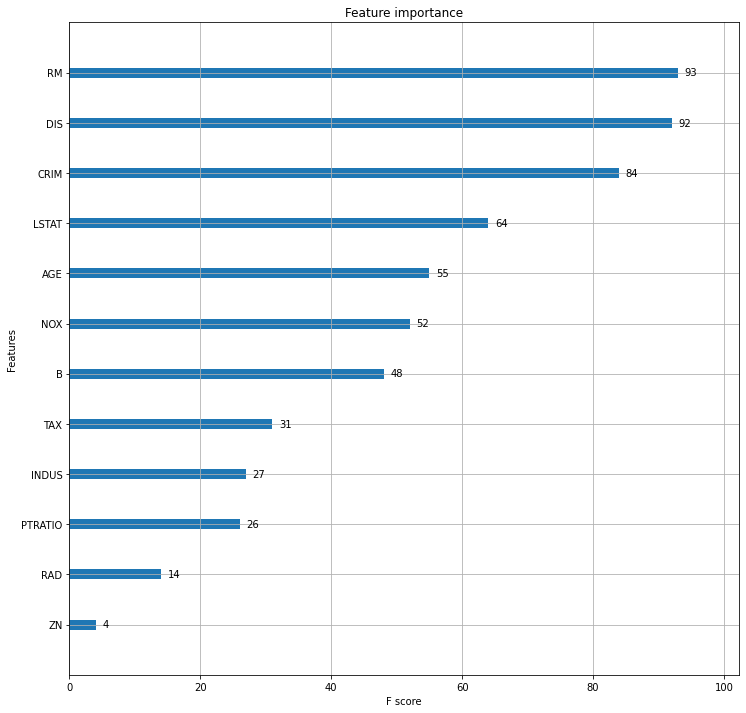

In [55]:
# 
xgb.plot_importance(grid.best_estimator_)


In [56]:
#check for overfitting

params = {'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'subsample': 0.8}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10,
                    num_boost_round=150, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True)

[]

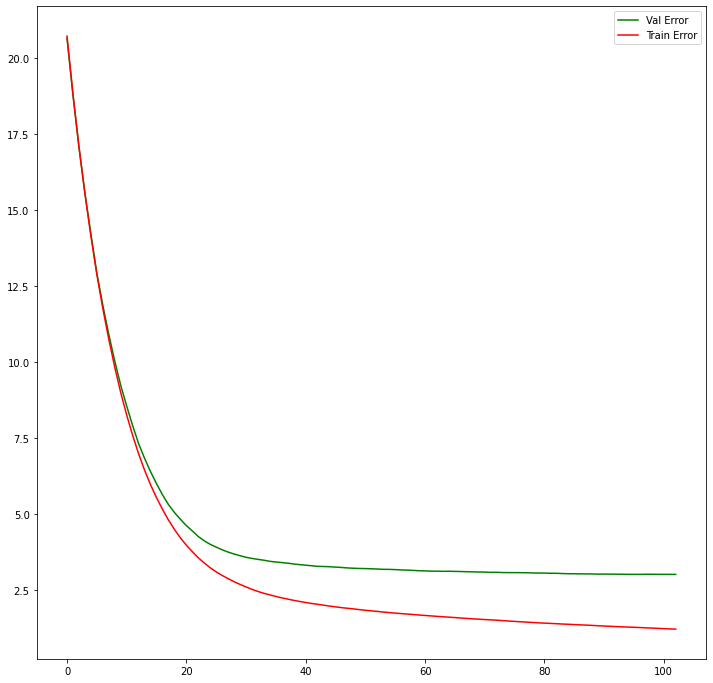

In [57]:
# plot train and val loss
ax = sns.lineplot(data = cv_results['test-rmse-mean'], color='g')
ax = sns.lineplot(data = cv_results['train-rmse-mean'], color='r',ax = ax)
plt.legend(["Val Error",  "Train Error"])
plt.plot()

In [58]:
# train model
xg_reg = xgb.train(params=params, dtrain=dmatrix,num_boost_round=40)

In [59]:
# Decision Tree metric
predict = xg_reg.predict(DMatrix(X_test))

print("Random forest Regressor Metric")
{'R2_Score': r2_score(y_test, predict),  'RMSE' :mean_squared_error(y_test, predict)**.5}

Random forest Regressor Metric


{'R2_Score': 0.8571396903959637, 'RMSE': 3.271989460479239}

### Thoughts...
The accuracy of SVM is the highest. so we will use SVM for final model

### Feature selection

In [60]:
# feature selctor
sfs = SequentialFeatureSelector(LassoCV(max_iter=5000, normalize=True),
          k_features=15,
          forward=True,
          floating=False,
          verbose=2,
          scoring='r2',
          cv=10)



In [61]:
#create pipeline
pipeline = make_pipeline(PolynomialFeatures(3), sfs, SVR(C=256, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma=0.05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))

# fit 
pipeline.fit(X_train, y_train)
# prediction
preds = pipe.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed:  3.4min finished

[2020-08-22 21:03:35] Features: 1/15 -- score: 0.600735660737378[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 454 out of 454 | elapsed:  3.4min finished

[2020-08-22 21:07:00] Features: 2/15 -- score: 0.6535020527672639[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 453 out of 453 | elapsed:  3.4min finished

[2020-08-22 21:10:24] Features: 3/15 -- score: 0.6964221452796278[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [62]:
print("SVM with feature selection Metric")
{'R2_Score': r2_score(y_test, preds),  'RMSE' :mean_squared_error(y_test, preds)**.5}

Random forest Regressor Metric


{'R2_Score': 0.9182841027168782, 'RMSE': 2.371876406858272}

## Conclusion

We achieved a r2 score of above .90, which is a fairly a good number. Analysed different algorithm and chossed best that generlized the data in a good manner. 

The data in which it is trained is of 1978 and guessing the price of house, from the data that is from 1970's is not going to be good prediction.

The features present in datase are not enough to describe or predict the price of house, as price of houses deppend on several other parameter such as area, furnishing, education services,etc

As the data we trained is only from urban city like Boston, and price of house of urban city and rural city are way to different so predicting the value of rural area house from this model might not be a good idea.
